In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from Metric import get_uplift_model_aucc
from model import slearner_criteo_uplift
from utils_ import * 
from Lagrangian_duality_gradient_estimator import * 
  


In [2]:
df_criteo = pd.read_csv('data/criteo-uplift-v2.1.csv', sep=',')

random_state = 20220720
df_criteo = df_criteo.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

In [3]:
df_criteo

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.859005,4.679882,10.280525,4.115453,0.294443,4.833815,3.910792,13.190056,5.300375,-0.168679,1,0,0,0
1,25.527349,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
2,24.753301,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
3,24.544662,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
4,26.311796,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,12.616365,10.059654,8.868975,4.679882,10.280525,4.115453,0.294443,4.833815,3.876391,13.190056,5.300375,-0.168679,1,0,0,0
13979588,14.974642,10.059654,8.214383,3.907662,10.280525,4.115453,-8.493011,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
13979589,14.461671,10.679513,8.214383,0.604065,10.280525,2.230907,-11.858523,7.900615,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
13979590,13.717872,10.059654,8.280712,2.587543,10.280525,4.115453,-17.661325,4.833815,3.800545,31.144700,5.300375,-0.168679,1,0,0,0


In [4]:
torch.manual_seed(202306)            
torch.cuda.manual_seed(202306)     
T = df_criteo['treatment'].values.reshape(-1, 1)
unique, counts = np.unique(T, return_counts=True)
weights = counts / len(T)

train_dl, X_val, T_val, Y_visit_val, Y_visit_float_val, Y_conv_val, Y_conv_float_val, X_test, T_test, Y_visit_test, Y_visit_float_test, Y_conv_test, Y_conv_float_test = get_data(df_criteo, weights, unique, 100000, 30) 
weights = torch.tensor(weights).cuda()
X_val, T_val, Y_visit_val, Y_conv_val = X_val.cuda(), T_val.cuda(), Y_visit_val.cuda(), Y_conv_val.cuda()


In [7]:

#train TS model
model_ts = slearner_criteo_uplift(12, 4).cuda()
optimizer = optim.Adam(model_ts.parameters(), lr=0.01)

loss_ts = nn.BCELoss()
max_val_aucc = 0
num_epoch = 20

for epoch in range(num_epoch):
    count = 0
    for data in train_dl:
        optimizer.zero_grad()
        
        x, t, y_visit, y_visit_float, y_conv, y_conv_float = data
        x, t, y_visit, y_visit_float, y_conv, y_conv_float = x.cuda(), t.cuda(), y_visit.cuda(), y_visit_float.cuda(), y_conv.cuda(), y_conv_float.cuda()
        T1 = torch.ones_like(t).cuda()
        T0 = torch.zeros_like(t).cuda()
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_ts(x, T0, T1)
        r = torch.cat([y_conv_pred_T0, y_conv_pred_T1], dim=1)
        c = torch.cat([y_visit_pred_T0, y_visit_pred_T1], dim=1)
        idx_T0 = torch.where(t==0)[0]
        idx_T1 = torch.where(t==1)[0]
        
        loss_ce = loss_ts(y_conv_pred_T1[idx_T1], y_conv[idx_T1]) + loss_ts(y_conv_pred_T0[idx_T0], y_conv[idx_T0]) + loss_ts(y_visit_pred_T1[idx_T1], y_visit[idx_T1]) + loss_ts(y_visit_pred_T0[idx_T0], y_visit[idx_T0])
        loss = loss_ce
        loss.backward()
        optimizer.step()

    if epoch >= 0:
        with torch.no_grad():
            T1 = torch.ones_like(T_val).cuda()
            T0 = torch.zeros_like(T_val).cuda()
            y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_ts(X_val, T0, T1)
            conv_pred = y_conv_pred_T1 - y_conv_pred_T0
            visit_pred = y_visit_pred_T1 - y_visit_pred_T0
            conv_pred = conv_pred.cpu().numpy()
            visit_pred =  visit_pred.cpu().numpy()
            roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
            val_aucc = get_uplift_model_aucc(t=(T_val.cpu().numpy() > 0.5).flatten(), yr=Y_conv_val.cpu().numpy().flatten(), yc=Y_visit_val.cpu().numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
            print(f'------epoch: {epoch+1}/{num_epoch}------val_aucc:{val_aucc[0]}------')
        if val_aucc[0] > max_val_aucc:
            max_val_aucc = val_aucc[0]
            torch.save(model_ts.state_dict(), 'Model/model_tsm.pkl') 

        
with torch.no_grad():

    model_ts_best = slearner_criteo_uplift(12, 4)
    model_ts_best.load_state_dict(torch.load('Model/model_tsm.pkl'))
    T1 = torch.ones_like(T_test)
    T0 = torch.zeros_like(T_test)
    y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_ts_best(X_test, T0, T1)
    conv_pred = y_conv_pred_T1 - y_conv_pred_T0
    visit_pred = y_visit_pred_T1 - y_visit_pred_T0
    conv_pred = conv_pred.numpy()
    visit_pred =  visit_pred.numpy()
    roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
    test_aucc_ts = get_uplift_model_aucc(t=(T_test.numpy() > 0.5).flatten(), yr=Y_conv_test.numpy().flatten(), yc=Y_visit_test.numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
    print(f'------warmstart finished!------val_aucc:{max_val_aucc}------test_aucc:{test_aucc_ts[0]}')


------epoch: 1/20------val_aucc:0.5249094877496759------
------epoch: 2/20------val_aucc:0.6120316905856908------
------epoch: 3/20------val_aucc:0.714579685405439------
------epoch: 4/20------val_aucc:0.6776466697874682------
------epoch: 5/20------val_aucc:0.7004307477701274------
------epoch: 6/20------val_aucc:0.6210628911230792------
------epoch: 7/20------val_aucc:0.7005723462015786------
------epoch: 8/20------val_aucc:0.706763744311268------
------epoch: 9/20------val_aucc:0.6385923746650574------
------epoch: 10/20------val_aucc:0.6282511940520014------
------epoch: 11/20------val_aucc:0.6733043876308383------
------epoch: 12/20------val_aucc:0.7057979393910159------
------epoch: 13/20------val_aucc:0.6466769044657376------
------epoch: 14/20------val_aucc:0.6965132753041079------
------epoch: 15/20------val_aucc:0.7173932698826474------
------epoch: 16/20------val_aucc:0.6157254055817979------
------epoch: 17/20------val_aucc:0.6993218130773036------
------epoch: 18/20------v

In [6]:
T = df_criteo['treatment'].values.reshape(-1, 1)
unique, counts = np.unique(T, return_counts=True)
weights = counts / len(T)

train_dl, X_val, T_val, Y_visit_val, Y_visit_float_val, Y_conv_val, Y_conv_float_val, X_test, T_test, Y_visit_test, Y_visit_float_test, Y_conv_test, Y_conv_float_test = get_data(df_criteo, weights, unique, 300000, 30) 
weights = torch.tensor(weights).cuda()
X_val, T_val, Y_visit_val, Y_visit_float_val, Y_conv_val, Y_conv_float_val = X_val.cuda(), T_val.cuda(), Y_visit_val.cuda(), Y_visit_float_val.cuda(), Y_conv_val.cuda(), Y_conv_float_val.cuda()

In [10]:
with torch.no_grad():

    model_ts_best = slearner_criteo_uplift(12, 4)
    model_ts_best.load_state_dict(torch.load('Model/model_tsm.pkl'))
    T1 = torch.ones_like(T_test)
    T0 = torch.zeros_like(T_test)
    y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_ts_best(X_test, T0, T1)
    conv_pred = y_conv_pred_T1 - y_conv_pred_T0
    visit_pred = y_visit_pred_T1 - y_visit_pred_T0
    conv_pred = conv_pred.numpy()
    visit_pred =  visit_pred.numpy()
    roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
    test_aucc_ts = get_uplift_model_aucc(t=(T_test.numpy() > 0.5).flatten(), yr=Y_conv_test.numpy().flatten(), yc=Y_visit_test.numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
    print(f'test_aucc:{test_aucc_ts[0]}')

test_aucc:0.7528439178153326


In [11]:

lambda_1 = 0.1
max_val_aucc = 0
num_epoch = 20
h = 0.3
model_ifd = slearner_criteo_uplift(12, 4).cuda()
model_ifd.load_state_dict(torch.load('Model/model_tsm.pkl'))
optimizer = optim.Adam(model_ifd.parameters(), lr=1e-5, weight_decay=1e-5)
for epoch in range(num_epoch):
    for data in train_dl:
        optimizer.zero_grad()
        x, t, y_visit, y_visit_float, y_conv, y_conv_float = data
        x, t, y_visit, y_visit_float, y_conv, y_conv_float = x.cuda(), t.cuda(), y_visit.cuda(), y_visit_float.cuda(), y_conv.cuda(), y_conv_float.cuda()
        row_idx = torch.arange(x.shape[0])
        T1 = torch.ones_like(t).cuda()
        T0 = torch.zeros_like(t).cuda()
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_ifd(x, T0, T1)
        r_hat = torch.cat([y_conv_pred_T0, y_conv_pred_T1], dim=1)
        c_hat = torch.cat([y_visit_pred_T0, y_visit_pred_T1], dim=1)
        idx_T0 = torch.where(t==0)[0]
        idx_T1 = torch.where(t==1)[0]
        
        
        dQ_dr1, dQ_dc1 = improved_finite_difference(t=t, yr=y_conv_float, yc=y_visit_float, r_hat=r_hat, c_hat=c_hat, lambda_=lambda_1, weights=weights, h=h, clip='fix')

        dQ_dr1, dQ_dc1 = dQ_dr1.detach(), dQ_dc1.detach()

        loss_dfl = -torch.matmul(r_hat.t(), dQ_dr1).trace()

        loss = loss_dfl
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model_ifd = model_ifd.cpu()
        T1 = torch.ones_like(T_test)
        T0 = torch.zeros_like(T_test)
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_ifd(X_test, T0, T1)
        conv_pred = y_conv_pred_T1 - y_conv_pred_T0
        visit_pred = y_visit_pred_T1 - y_visit_pred_T0
        conv_pred = conv_pred.numpy()
        visit_pred =  visit_pred.numpy()
        roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
        test_aucc = get_uplift_model_aucc(t=(T_test.numpy() > 0.5).flatten(), yr=Y_conv_test.numpy().flatten(), yc=Y_visit_test.numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
        model_ifd = model_ifd.cuda()

    with torch.no_grad():
        T1 = torch.ones_like(T_val).cuda()
        T0 = torch.zeros_like(T_val).cuda()
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_ifd(X_val, T0, T1)
        conv_pred = y_conv_pred_T1 - y_conv_pred_T0
        visit_pred = y_visit_pred_T1 - y_visit_pred_T0
        conv_pred = conv_pred.cpu().numpy()
        visit_pred =  visit_pred.cpu().numpy()
        roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
        val_aucc = get_uplift_model_aucc(t=(T_val.cpu().numpy() > 0.5).flatten(), yr=Y_conv_val.cpu().numpy().flatten(), yc=Y_visit_val.cpu().numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
        if val_aucc[0] > max_val_aucc:
            max_val_aucc = val_aucc[0]
            torch.save(model_ifd.state_dict(), 'Model/model_ifd.pkl')
    
    print(f'------epoch: {epoch+1}/{num_epoch}------val_aucc:{val_aucc[0]}------test_aucc:{test_aucc[0]}------')
    


with torch.no_grad():
    model_ifd_best = slearner_criteo_uplift(12, 4)
    model_ifd_best.load_state_dict(torch.load('Model/model_ifd.pkl'))
    T1 = torch.ones_like(T_test)
    T0 = torch.zeros_like(T_test)
    y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_ifd_best(X_test, T0, T1)
    conv_pred = y_conv_pred_T1 - y_conv_pred_T0
    visit_pred = y_visit_pred_T1 - y_visit_pred_T0
    conv_pred = conv_pred.numpy()
    visit_pred =  visit_pred.numpy()
    roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
    test_aucc_ifd = get_uplift_model_aucc(t=(T_test.numpy() > 0.5).flatten(), yr=Y_conv_test.numpy().flatten(), yc=Y_visit_test.numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
    print(f'------ifd finetune finished!------val_aucc:{max_val_aucc}------test_aucc:{test_aucc_ifd[0]}')


------epoch: 1/20------val_aucc:0.7206152942128495------test_aucc:0.7499543531643457------
------epoch: 2/20------val_aucc:0.6953857841308353------test_aucc:0.7502545578623436------
------epoch: 3/20------val_aucc:0.7017257398135155------test_aucc:0.7542809738647459------
------epoch: 4/20------val_aucc:0.7015529505469758------test_aucc:0.7561869332850738------
------epoch: 5/20------val_aucc:0.7088500833219622------test_aucc:0.759212430604953------
------epoch: 6/20------val_aucc:0.7107910959178101------test_aucc:0.7645729186081665------
------epoch: 7/20------val_aucc:0.7120433612102477------test_aucc:0.7692858179478619------
------epoch: 8/20------val_aucc:0.7062633277170091------test_aucc:0.7760942928924979------
------epoch: 9/20------val_aucc:0.7141784608855882------test_aucc:0.7791260593021728------
------epoch: 10/20------val_aucc:0.7179711447773661------test_aucc:0.7829086699516645------
------epoch: 11/20------val_aucc:0.7215497084120952------test_aucc:0.7863979609865124-----

In [12]:
lambda_1 = 0.1
max_val_aucc = 0
aucc_list = []
model_pl = slearner_criteo_uplift(12, 4).cuda()
model_pl.load_state_dict(torch.load('Model/model_tsm.pkl'))
optimizer = optim.Adam(model_pl.parameters(), lr=1e-5, weight_decay=1e-5)
for epoch in range(20):
    count = 0
    for data in train_dl:
        optimizer.zero_grad()
        x, t, y_visit, y_visit_float, y_conv, y_conv_float = data
        x, t, y_visit, y_visit_float, y_conv, y_conv_float = x.cuda(), t.cuda(), y_visit.cuda(), y_visit_float.cuda(), y_conv.cuda(), y_conv_float.cuda()
        row_idx = torch.arange(x.shape[0])
        
        T1 = torch.ones_like(t).cuda()
        T0 = torch.zeros_like(t).cuda()
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_pl(x, T0, T1)
        t = t.squeeze()
        r = torch.cat([y_conv_pred_T0, y_conv_pred_T1], dim=1)
        c = torch.cat([y_visit_pred_T0, y_visit_pred_T1], dim=1)
        idx_T0 = torch.where(t==0)[0]
        idx_T1 = torch.where(t==1)[0]
        
        
        a1 = nn.functional.softmax(r-lambda_1*c, dim=1)

        loss_dfl = - torch.mean((y_conv - lambda_1*y_visit).squeeze().detach() * a1[row_idx, t.long()])

        loss = loss_dfl
        loss.backward()
        optimizer.step()
        count += 1

    with torch.no_grad():
        model_pl = model_pl.cpu()
        T1 = torch.ones_like(T_test)
        T0 = torch.zeros_like(T_test)
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_pl(X_test, T0, T1)
        conv_pred = y_conv_pred_T1 - y_conv_pred_T0
        visit_pred = y_visit_pred_T1 - y_visit_pred_T0
        conv_pred = conv_pred.numpy()
        visit_pred =  visit_pred.numpy()
        roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
        test_aucc = get_uplift_model_aucc(t=(T_test.numpy() > 0.5).flatten(), yr=Y_conv_test.numpy().flatten(), yc=Y_visit_test.numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
        model_pl = model_pl.cuda()

    with torch.no_grad():
        T1 = torch.ones_like(T_val).cuda()
        T0 = torch.zeros_like(T_val).cuda()
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_pl(X_val, T0, T1)
        conv_pred = y_conv_pred_T1 - y_conv_pred_T0
        visit_pred = y_visit_pred_T1 - y_visit_pred_T0
        conv_pred = conv_pred.cpu().numpy()
        visit_pred =  visit_pred.cpu().numpy()
        roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
        val_aucc = get_uplift_model_aucc(t=(T_val.cpu().numpy() > 0.5).flatten(), yr=Y_conv_val.cpu().numpy().flatten(), yc=Y_visit_val.cpu().numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
        if val_aucc[0] > max_val_aucc:
            max_val_aucc = val_aucc[0]
            torch.save(model_pl.state_dict(), 'Model/model_pl.pkl')

    print(f'------epoch: {epoch+1}/{num_epoch}------val_aucc:{val_aucc[0]}------test_aucc:{test_aucc[0]}------')



with torch.no_grad():
    model_pl_best = slearner_criteo_uplift(12, 4)
    model_pl_best.load_state_dict(torch.load('Model/model_pl.pkl'))
    T1 = torch.ones_like(T_test)
    T0 = torch.zeros_like(T_test)
    y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_pl_best(X_test, T0, T1)
    idx_T0 = torch.where(T_test==0)[0]
    idx_T1 = torch.where(T_test==1)[0]
    conv_pred = y_conv_pred_T1 - y_conv_pred_T0
    visit_pred = y_visit_pred_T1 - y_visit_pred_T0
    conv_pred = conv_pred.numpy()
    visit_pred =  visit_pred.numpy()
    roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
    test_aucc_pl = get_uplift_model_aucc(t=(T_test.numpy() > 0.5).flatten(), yr=Y_conv_test.numpy().flatten(), yc=Y_visit_test.numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
    print(f'------pl finetune finished!------val_aucc:{max_val_aucc}------test_aucc:{test_aucc_pl[0]}')


------epoch: 1/20------val_aucc:0.7123466645701491------test_aucc:0.7553001109726597------
------epoch: 2/20------val_aucc:0.7123218616731425------test_aucc:0.7614705459486745------
------epoch: 3/20------val_aucc:0.7194558879213273------test_aucc:0.7587119803444324------
------epoch: 4/20------val_aucc:0.7167209563985821------test_aucc:0.7552255126894228------
------epoch: 5/20------val_aucc:0.731935339444738------test_aucc:0.7572628241328787------
------epoch: 6/20------val_aucc:0.7371856180230251------test_aucc:0.7617229519322019------
------epoch: 7/20------val_aucc:0.7347271156080347------test_aucc:0.7643643766733063------
------epoch: 8/20------val_aucc:0.7366776949353806------test_aucc:0.7713166134108591------
------epoch: 9/20------val_aucc:0.732619892231932------test_aucc:0.7651514421390739------
------epoch: 10/20------val_aucc:0.736539994301389------test_aucc:0.7695462957834763------
------epoch: 11/20------val_aucc:0.7389559455585833------test_aucc:0.7786474678498391------


In [11]:
lambda_1 = 0.1
max_val_aucc = 0
tau = 3
num_epoch = 20

aucc_list = []
model_mer = slearner_criteo_uplift(12, 4).cuda()
model_mer.load_state_dict(torch.load('Model/model_tsm.pkl'))
optimizer = optim.Adam(model_mer.parameters(), lr=1e-5, weight_decay=1e-5)
for epoch in range(num_epoch):
    count = 0
    for data in train_dl:
        optimizer.zero_grad()
        x, t, y_visit, y_visit_float, y_conv, y_conv_float = data
        x, t, y_visit, y_visit_float, y_conv, y_conv_float = x.cuda(), t.cuda(), y_visit.cuda(), y_visit_float.cuda(), y_conv.cuda(), y_conv_float.cuda()
        row_idx = torch.arange(x.shape[0])
        
        T1 = torch.ones_like(t).cuda()
        T0 = torch.zeros_like(t).cuda()
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_mer(x, T0, T1)
        t = t.squeeze()
        r = torch.cat([y_conv_pred_T0, y_conv_pred_T1], dim=1)
        c = torch.cat([y_visit_pred_T0, y_visit_pred_T1], dim=1)
        idx_T0 = torch.where(t==0)[0]
        idx_T1 = torch.where(t==1)[0]
        
        
        a1 = nn.functional.softmax((r-lambda_1*c)/tau, dim=1)


        loss_dfl = - torch.mean((y_conv - lambda_1*y_visit).squeeze().detach() * a1[row_idx, t.long()])

        loss = loss_dfl
        loss.backward()
        optimizer.step()
        count += 1

    with torch.no_grad():
        model_mer = model_mer.cpu()
        T1 = torch.ones_like(T_test)
        T0 = torch.zeros_like(T_test)
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_mer(X_test, T0, T1)
        conv_pred = y_conv_pred_T1 - y_conv_pred_T0
        visit_pred = y_visit_pred_T1 - y_visit_pred_T0
        conv_pred = conv_pred.numpy()
        visit_pred =  visit_pred.numpy()
        roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
        test_aucc = get_uplift_model_aucc(t=(T_test.numpy() > 0.5).flatten(), yr=Y_conv_test.numpy().flatten(), yc=Y_visit_test.numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
        model_mer = model_mer.cuda()

    with torch.no_grad():
        T1 = torch.ones_like(T_val).cuda()
        T0 = torch.zeros_like(T_val).cuda()
        y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_mer(X_val, T0, T1)
        conv_pred = y_conv_pred_T1 - y_conv_pred_T0
        visit_pred = y_visit_pred_T1 - y_visit_pred_T0
        conv_pred = conv_pred.cpu().numpy()
        visit_pred =  visit_pred.cpu().numpy()
        roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
        val_aucc = get_uplift_model_aucc(t=(T_val.cpu().numpy() > 0.5).flatten(), yr=Y_conv_val.cpu().numpy().flatten(), yc=Y_visit_val.cpu().numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
        if val_aucc[0] > max_val_aucc:
            max_val_aucc = val_aucc[0]
            torch.save(model_mer.state_dict(), 'Model/model_mer.pkl')

    print(f'------epoch: {epoch+1}/{num_epoch}------val_aucc:{val_aucc[0]}------test_aucc:{test_aucc[0]}------')



with torch.no_grad():
    model_mer_best = slearner_criteo_uplift(12, 4)
    model_mer_best.load_state_dict(torch.load('Model/model_mer.pkl'))
    T1 = torch.ones_like(T_test)
    T0 = torch.zeros_like(T_test)
    y_visit_pred_T0, y_visit_pred_T1, y_conv_pred_T0, y_conv_pred_T1 = model_mer_best(X_test, T0, T1)
    idx_T0 = torch.where(T_test==0)[0]
    idx_T1 = torch.where(T_test==1)[0]
    conv_pred = y_conv_pred_T1 - y_conv_pred_T0
    visit_pred = y_visit_pred_T1 - y_visit_pred_T0
    conv_pred = conv_pred.numpy()
    visit_pred =  visit_pred.numpy()
    roi_pred = conv_pred / np.where(abs(visit_pred) < 1e-6, 1e-6, visit_pred)
    test_aucc_mer = get_uplift_model_aucc(t=(T_test.numpy() > 0.5).flatten(), yr=Y_conv_test.numpy().flatten(), yc=Y_visit_test.numpy().flatten(), roi_pred=roi_pred.flatten(), quantile=200)
    print(f'------mer finetune finished!------val_aucc:{max_val_aucc}------test_aucc:{test_aucc_mer[0]}')


------epoch: 1/20------val_aucc:0.708461778258508------test_aucc:0.7555353953403212------
------epoch: 2/20------val_aucc:0.7129542493236759------test_aucc:0.7517293826378056------
------epoch: 3/20------val_aucc:0.7009244425184444------test_aucc:0.7585366401644258------
------epoch: 4/20------val_aucc:0.7132998834418928------test_aucc:0.7609693819340758------
------epoch: 5/20------val_aucc:0.719302828555129------test_aucc:0.7636307315207628------
------epoch: 6/20------val_aucc:0.714918818856563------test_aucc:0.7630965087302137------
------epoch: 7/20------val_aucc:0.7165523565897167------test_aucc:0.760096723959527------
------epoch: 8/20------val_aucc:0.7193516192916287------test_aucc:0.7592086290817717------
------epoch: 9/20------val_aucc:0.7231142367415316------test_aucc:0.762806235736229------
------epoch: 10/20------val_aucc:0.7214614300823438------test_aucc:0.7622303423770715------
------epoch: 11/20------val_aucc:0.7252089597261162------test_aucc:0.7633351794052465------
--

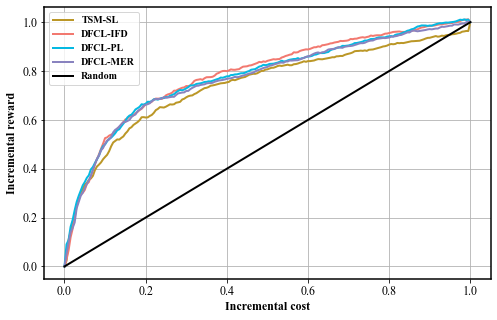

In [18]:
plt.figure(figsize=(8, 5))
plt.rc('font', family='Times New Roman')

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth('1.5')

ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth('1.5')

ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth('1.5')


ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth('1.5')




x_index = test_aucc_ts[1]
y_random = test_aucc_ts[2][-1] / x_index[-1] * x_index

x_normalization = x_index[-1]
y_normalization = test_aucc_ts[2][-1]


plt.figure(1)
plt.plot(x_index / x_normalization, test_aucc_ts[2] / y_normalization, color='#BB9727', label='TSM-SL', linewidth=2)
plt.plot(x_index / x_normalization, test_aucc_ifd[2] / y_normalization, color='#F27970', label='DFCL-IFD', linewidth=2)
plt.plot(x_index / x_normalization, test_aucc_pl[2] / y_normalization, color='#05B9E2', label='DFCL-PL', linewidth=2)
plt.plot(x_index / x_normalization, test_aucc_mer[2] / y_normalization, color='#8983BF', label='DFCL-MER', linewidth=2)

plt.plot(x_index / x_normalization, y_random / y_normalization, color='#000000', label='Random', linewidth=2)

plt.xlabel('Incremental cost', fontsize=12, fontweight='bold')
plt.ylabel('Incremental reward', fontsize=12, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.grid(True)
plt.legend(prop={'weight':"bold"})
# plt.legend()

plt.savefig('avg_aucc_criteo.pdf', format='pdf', bbox_inches = 'tight', dpi=1200)

plt.show()